## Backtesting
### Datos Sintéticos
En este cuaderno se presenta la generación de datos sintéticos de mercado con características similares a las vistas
en las series reales. Entre los objetivos de disponer de datos sintéticos podemos destacar:
- Poder simular escenarios más alla de la serie histórica de precios de la que disponemos
- Realizar la parte de desarrollo de las estrategias de trading sin hacer simulaciones continuas sobre la serie histórica 
para disminuir el riesgo de caer en el sesgo de selección

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Generación Aleatoria Multivariable
Si generamos por separado variables aleatorias que siguen una distribución normal,
estas serán independientes

In [2]:
x1 = np.random.randn(5000)
x2 = np.random.randn(5000)

(array([   7.,   55.,  269.,  776., 1358., 1271.,  855.,  333.,   69.,
           7.]),
 array([-3.71057642, -2.97810613, -2.24563585, -1.51316556, -0.78069528,
        -0.048225  ,  0.68424529,  1.41671557,  2.14918586,  2.88165614,
         3.61412643]),
 <a list of 10 Patch objects>)

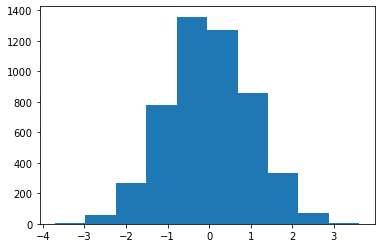

In [4]:
plt.hist(x1)

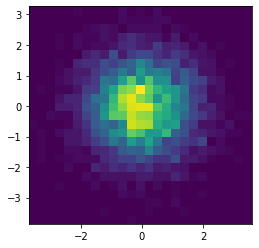

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.hist2d(x1, x2, bins=25)

Una distribución normal multivariable está determinada por 
las medias de las variables y su matriz de covarianzas

In [16]:
scov = np.array([[1, 0.9],
                 [0.9, 1]])
scov

array([[1. , 0.9],
       [0.9, 1. ]])

In [17]:
np.random.multivariate_normal([0, 0], scov, size=5)

array([[-0.30069196, -1.07436335],
       [ 1.32583647,  1.03046916],
       [ 1.46582873,  0.79510864],
       [ 0.56943119,  1.13688064],
       [ 0.88605573,  0.53523667]])

In [18]:
rnd2d_samples = np.random.multivariate_normal([0, 0], scov, size=5000)

In [19]:
x1 = rnd2d_samples[:,0]
x2 = rnd2d_samples[:,1]

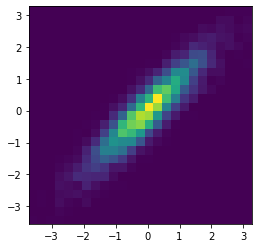

In [20]:
fig, ax = plt.subplots(figsize=(4,4))
_ = ax.hist2d(x1, x2, bins=25)

___

## Proceso aleatorio con deriva

Si asumimos que una serie de precios la podemos modelar con un camino aleatorio con deriva, este quedaría
expresado como 

$$P_t = \alpha + Pt_{t-1} + \epsilon$$

donde:
- $\alpha$ estaría representando el cambio subyacente de precio justificado por los fundamentales
- $\epsilon$ es el término de error generado por el proceso estocástico y determinado por la volatilidad



In [21]:
def rndwalk_drift_series(p0, exp_ret, sigma, n):
    log_prices = np.zeros(n)
    log_prices[0] = np.log(p0)
    
    for i in range(1, n):
        log_prices[i] = log_prices[i-1] + exp_ret + sigma*np.random.randn()
    return np.exp(log_prices)    

In [26]:
rnd_stock = rndwalk_drift_series(10, 0.001, 0.01, 250)

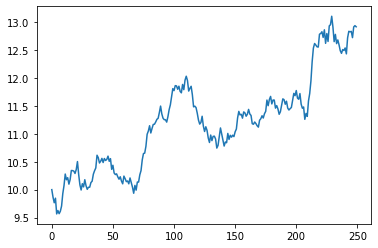

In [27]:
plt.plot(rnd_stock)

___

### Datos

In [28]:
ticker_list = ['BBVA','SAN','REP','TEF','IBE','FER','ITX','ACS','AMS','GRF']

In [29]:
import pickle
with open('../data/stock_data.pkl', 'rb') as handle:
    stock_data = pickle.load(handle)

In [30]:
close_series = {ticker: df.close
                for ticker, df in stock_data.items()
                if ticker in ticker_list
               }
stock_df = pd.DataFrame(close_series)
stock_df = stock_df.loc['2016':]

___

Hacemos la prueba de ver otros posibles caminos con propiedades similares

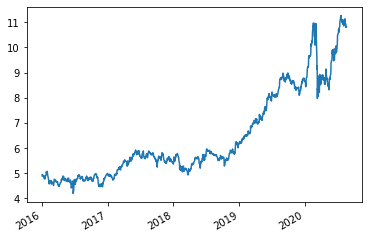

In [32]:
stock_price = stock_df['IBE']
stock_price.plot()

In [39]:
stock_ret = np.log(stock_price).diff()
ret_mean = stock_ret.iloc[:250].mean()
ret_std = stock_ret.iloc[:250].std()
ret_mean, ret_std

(-2.461226568847094e-05, 0.013160653067118567)

In [40]:
stock_real = stock_price[:250]

In [41]:
stock_paths = []
for i in range(8):
    rnd_path = rndwalk_drift_series(stock_real.iloc[0], ret_mean, ret_std, 250)
    rnd_series = pd.Series(
        rnd_path, 
        index=stock_real.index,
        name=f'rnd{i}'
    )
    stock_paths.append(rnd_series)

In [42]:
rnd_df = pd.concat(stock_paths, axis=1)
rnd_df.head()

,rnd0,rnd1,rnd2,rnd3,rnd4,rnd5,rnd6,rnd7
2016-01-04,4.891871,4.891871,4.891871,4.891871,4.891871,4.891871,4.891871,4.891871
2016-01-05,4.797792,4.845640,4.870401,4.885303,4.881152,4.955406,4.950791,4.936342
2016-01-06,4.835743,4.899411,4.865373,4.910116,4.955272,4.874039,4.936239,4.917106
2016-01-07,4.872744,4.955303,4.894348,4.993186,4.945338,4.797708,4.838266,4.896455
2016-01-08,4.815337,4.867484,4.938774,5.039246,4.838500,4.799887,4.738603,4.820072


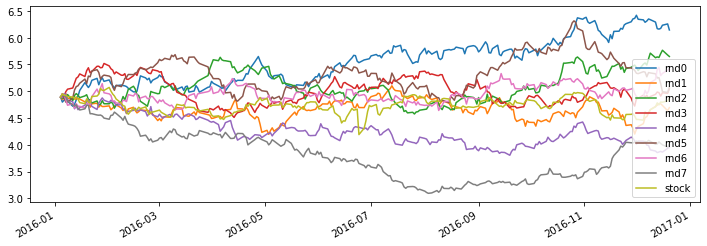

In [43]:
rnd_df['stock'] = stock_real
rnd_df.plot(figsize=(12, 4))

In [44]:
simu_rets = np.log(rnd_df).diff().dropna()
simu_rets.describe()

,rnd0,rnd1,rnd2,rnd3,rnd4,rnd5,rnd6,rnd7,stock
count,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000,249.000000
mean,0.000916,-0.000165,0.000578,0.000125,-0.000857,0.000150,0.000400,-0.000803,-0.000025
std,0.012269,0.013092,0.012312,0.012203,0.012037,0.012925,0.013073,0.012178,0.013161
min,-0.030543,-0.037784,-0.028513,-0.037094,-0.034010,-0.033899,-0.033616,-0.034426,-0.107593
25%,-0.007144,-0.009384,-0.008238,-0.007754,-0.008639,-0.008346,-0.009214,-0.008873,-0.006568
50%,0.001378,0.000628,0.001734,0.000590,-0.001475,-0.000282,-0.000243,-0.000850,-0.000167
75%,0.008914,0.009425,0.009103,0.009182,0.008070,0.009129,0.009285,0.008028,0.006642
max,0.028909,0.026521,0.034383,0.027905,0.028542,0.037208,0.035394,0.039461,0.039131


___

### Generación Sintética de Escenarios Combinados
En la realidad se ha visto que las expectativas de mercado cambian y la volatilidad no es constante.
Para considerar estas propiedades vamos a muestrear las propiedades estadísticas de períodos históricos
y a replicarlos por periodos arbitrarios dentro de los datos generados.

In [45]:
def sample_market_rets(df, window):
    n_all_days = df.shape[0]
    available_size = n_all_days - window
    start = np.random.randint(0, available_size)
    
    market_snapshot = df.iloc[start: start+window, :]
    rets = np.log(market_snapshot).diff().dropna()
    rets.reset_index(drop=True, inplace=True)
    return rets

In [46]:
market_ret = sample_market_rets(stock_df, 60)
market_ret.head()

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
0,0.008267,-0.006154,-0.005081,-0.008105,-0.016078,-0.002074,0.001387,0.013100,-0.010060,-0.002700
1,0.007439,0.011660,0.012969,0.014142,0.016078,0.004462,0.009998,0.011541,0.020019,0.016221
2,-0.003045,0.022025,0.000942,-0.001673,0.016216,0.008392,0.036049,-0.005229,0.024033,0.012465
3,0.009297,0.012456,-0.006299,0.004344,-0.002357,0.013625,-0.011984,0.007660,0.011803,0.004494
4,-0.012352,-0.009774,-0.020751,-0.011402,0.010172,-0.009848,-0.002683,0.005879,-0.035386,-0.004369


In [47]:
market_ret.mean()

SAN    -0.001602
FER     0.002192
ACS     0.002310
AMS     0.003201
ITX     0.002985
BBVA   -0.000472
IBE     0.002208
REP     0.003368
GRF     0.003307
TEF    -0.000488
dtype: float64

In [49]:
market_ret.corr().style.background_gradient()

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
SAN,1.000000,0.444435,0.587224,0.216588,0.144201,0.849722,0.428779,0.463230,0.387721,0.650446
FER,0.444435,1.000000,0.459117,0.237614,0.208996,0.447941,0.484557,0.206166,0.298913,0.606812
ACS,0.587224,0.459117,1.000000,0.346133,0.048729,0.539984,0.440951,0.538947,0.454958,0.562284
AMS,0.216588,0.237614,0.346133,1.000000,0.259472,0.144285,0.068827,0.143721,0.393734,0.193511
ITX,0.144201,0.208996,0.048729,0.259472,1.000000,0.140215,0.305795,-0.127581,0.127537,0.302148
BBVA,0.849722,0.447941,0.539984,0.144285,0.140215,1.000000,0.509067,0.506413,0.370219,0.611388
IBE,0.428779,0.484557,0.440951,0.068827,0.305795,0.509067,1.000000,0.283647,0.222865,0.491363
REP,0.463230,0.206166,0.538947,0.143721,-0.127581,0.506413,0.283647,1.000000,0.088445,0.325702
GRF,0.387721,0.298913,0.454958,0.393734,0.127537,0.370219,0.222865,0.088445,1.000000,0.318282
TEF,0.650446,0.606812,0.562284,0.193511,0.302148,0.611388,0.491363,0.325702,0.318282,1.000000


____
Para la generación vamos a concatenar la réplica de los diferentes contextos de mercado. Los pasos serían
  1. Muestrear e identificar los parámetros del contexto 
  2. Elegir de forma aleatoria durante cuánto tiempo se va reproducir ese contexto
  3. Generar la distribución aleatoria multivariable de retornos
  4. Transformar los retornos a precios desde el punto de partida deseado

In [72]:
n = 20
win_sample = 100

In [73]:
ret_list = []
for i in range(n):
    # Paso 1
    market_ret = sample_market_rets(stock_df, win_sample)
    i_mean = market_ret.mean()
    i_covmat = market_ret.cov()
    
    # Paso 2
    fwd_win = np.random.randint(40,120)
    
    # Paso 3 
    rnd_rets = np.random.multivariate_normal(i_mean, i_covmat, size=fwd_win)
    rnd_rets_df = pd.DataFrame(rnd_rets, columns=stock_df.columns)
    ret_list.append(rnd_rets_df)

In [74]:
all_rets = pd.concat(ret_list)
all_rets.reset_index(inplace=True, drop=True)

In [75]:
all_rets.shape

(1521, 10)

In [76]:
all_rets.head()

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
0,0.006910,-0.002608,0.003993,0.004165,-0.006911,0.009414,-0.010357,0.026057,-0.001928,-0.002631
1,-0.000684,-0.002498,-0.015107,0.008654,0.010962,-0.004966,0.001414,0.000871,0.010015,0.003993
2,0.022878,0.002678,0.004749,-0.006777,0.013120,0.021541,-0.013601,-0.006843,0.014638,0.011247
3,0.031008,-0.010342,-0.002230,0.010179,0.007070,0.039947,-0.004420,-0.011526,0.002894,0.006744
4,0.016945,-0.001291,0.022767,0.006097,-0.000457,0.012516,0.000134,0.012340,-0.008198,0.004490


Pasamos de rendimientos a precios a partir del último precio de la serie real (Paso 4)

In [77]:
# Necesitamos un valor adicional que sera el precio inicial
logprices = np.zeros((all_rets.shape[0]+1, all_rets.shape[1]))
logprices[0] = np.log(stock_df.iloc[0])
logprices[1:,:] = all_rets.values
logprices = logprices.cumsum(axis=0)
prices = pd.DataFrame(np.exp(logprices), columns=stock_df.columns)

In [78]:
prices

,SAN,FER,ACS,AMS,ITX,BBVA,IBE,REP,GRF,TEF
0,3.611336,17.329551,20.205989,36.609084,27.617815,5.100387,4.891871,6.709067,19.346262,7.848238
1,3.636377,17.284413,20.286824,36.761889,27.427616,5.148628,4.841466,6.886181,19.308989,7.827617
2,3.633891,17.241295,19.982663,37.081420,27.729944,5.123122,4.848319,6.892183,19.503344,7.858932
3,3.717986,17.287534,20.077782,36.830976,28.096157,5.234674,4.782824,6.845181,19.790929,7.947820
4,3.835078,17.109659,20.033058,37.207792,28.295495,5.448014,4.761731,6.766734,19.848286,8.001598
...,...,...,...,...,...,...,...,...,...,...
1517,6.557123,38.720107,44.662586,98.231844,45.644687,10.002057,17.732502,25.948144,66.819359,5.064833
1518,6.315882,39.082469,44.192783,98.227174,44.606648,9.641881,17.464265,25.481749,66.818820,4.906655
1519,6.056374,38.086167,43.405312,98.057857,43.986642,9.492905,17.298032,25.116691,66.426748,4.795377
1520,6.109248,37.584333,42.895169,96.474229,43.082444,9.576008,17.042566,24.567393,65.906177,4.741416


____
### Ejercicios Propuestos
1. Generar al menos 4 años de datos sintéticos
2. Elegir un ticker para comparar las distribución de rendimientos entre las series históricas y generadas.
3. Ver la evolución histórica de series generadas de BBVA y SAN

In [79]:
compare_df = prices[['SAN','BBVA']]

In [80]:
compare_df.loc[:, 'SAN'] = compare_df.loc[:,'SAN']/compare_df.iloc[0,0]
compare_df.loc[:, 'BBVA'] = compare_df.loc[:,'BBVA']/compare_df.iloc[0,1]

C:\Users\trosa\Anaconda3\lib\site-packages\pandas\core\indexing.py:1048: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


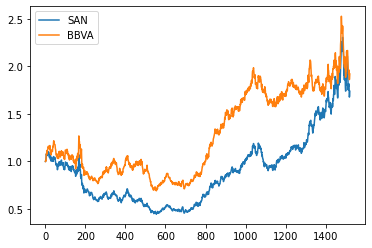

In [81]:
compare_df.plot()